# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [5]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        
        W1 = W1 - (eta * grad_W1)
        W2 = W2 - (eta * grad_W2)
        b1 = b1 - (eta * grad_b1)
        b2 = b2 - (eta * grad_b2)


    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305912 Accuracy 0.097143
Epoch 10 Loss 2.296942 Accuracy 0.097143
Epoch 20 Loss 2.287377 Accuracy 0.097143
Epoch 30 Loss 2.276737 Accuracy 0.147143
Epoch 40 Loss 2.264737 Accuracy 0.190000
Epoch 50 Loss 2.251216 Accuracy 0.235429
Epoch 60 Loss 2.236097 Accuracy 0.346000
Epoch 70 Loss 2.219404 Accuracy 0.476000
Epoch 80 Loss 2.201280 Accuracy 0.558000
Epoch 90 Loss 2.181887 Accuracy 0.594000
Epoch 100 Loss 2.161388 Accuracy 0.606857
Epoch 110 Loss 2.139949 Accuracy 0.610000
Epoch 120 Loss 2.117733 Accuracy 0.610857
Epoch 130 Loss 2.094895 Accuracy 0.610857
Epoch 140 Loss 2.071573 Accuracy 0.608571
Epoch 150 Loss 2.047887 Accuracy 0.608571
Epoch 160 Loss 2.023940 Accuracy 0.610000
Epoch 170 Loss 1.999834 Accuracy 0.611143
Epoch 180 Loss 1.975671 Accuracy 0.610000
Epoch 190 Loss 1.951523 Accuracy 0.612000
Epoch 200 Loss 1.927445 Accuracy 0.616857
Epoch 210 Loss 1.903485 Accuracy 0.619714
Epoch 220 Loss 1.879683 Accuracy 0.623143
Epoch 230 Loss 1.856077 Accuracy 0.627714
Epo

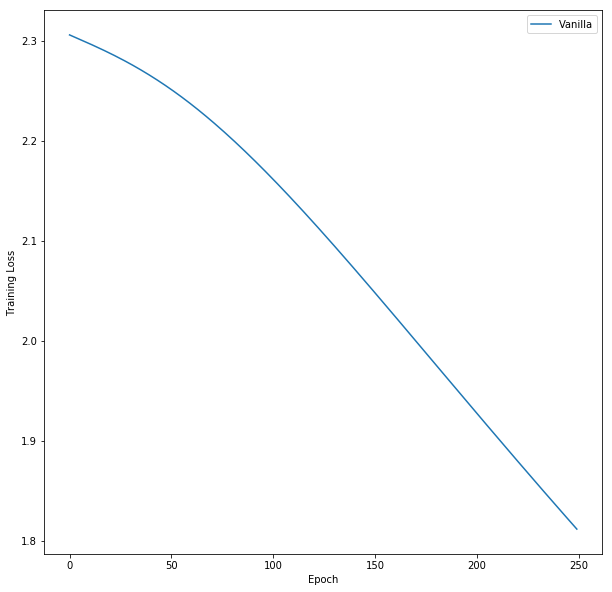

In [6]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [11]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add another hyper parameter here. Hint! look at the equation above
"""

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

"""
You probably need to initialize your momentum here... 
"""

m_w1 = grad_W1
m_w2 = grad_W2
m_b1 = grad_b1
m_b2 = grad_b2

beta = 0.9

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        m_w1 = (beta * m_w1) + ((1.0 - beta) * grad_W1)
        m_w2 = (beta * m_w2) + ((1.0 - beta) * grad_W2)

        m_b1 = (beta * m_b1) + ((1.0 - beta) * grad_b1)
        m_b2 = (beta * m_b2) + ((1.0 - beta) * grad_b2)

        
        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        W1 = W1 - (eta * m_w1)
        W2 = W2 - (eta * m_w2)
        
        b1 = b1 - (eta * m_b1)
        b2 = b2 - (eta * m_b2)

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305923 Accuracy 0.097143
Epoch 10 Loss 2.296933 Accuracy 0.097143
Epoch 20 Loss 2.287354 Accuracy 0.097143
Epoch 30 Loss 2.276701 Accuracy 0.147143
Epoch 40 Loss 2.264690 Accuracy 0.190000
Epoch 50 Loss 2.251157 Accuracy 0.234857
Epoch 60 Loss 2.236022 Accuracy 0.346857
Epoch 70 Loss 2.219314 Accuracy 0.477429
Epoch 80 Loss 2.201172 Accuracy 0.560286
Epoch 90 Loss 2.181760 Accuracy 0.594286
Epoch 100 Loss 2.161238 Accuracy 0.608000
Epoch 110 Loss 2.139776 Accuracy 0.609714
Epoch 120 Loss 2.117536 Accuracy 0.610857
Epoch 130 Loss 2.094672 Accuracy 0.609714
Epoch 140 Loss 2.071324 Accuracy 0.608286
Epoch 150 Loss 2.047614 Accuracy 0.608000
Epoch 160 Loss 2.023643 Accuracy 0.608857
Epoch 170 Loss 1.999516 Accuracy 0.610571
Epoch 180 Loss 1.975333 Accuracy 0.608857
Epoch 190 Loss 1.951167 Accuracy 0.612286
Epoch 200 Loss 1.927072 Accuracy 0.617143
Epoch 210 Loss 1.903096 Accuracy 0.619714
Epoch 220 Loss 1.879279 Accuracy 0.623429
Epoch 230 Loss 1.855661 Accuracy 0.627143
Epo

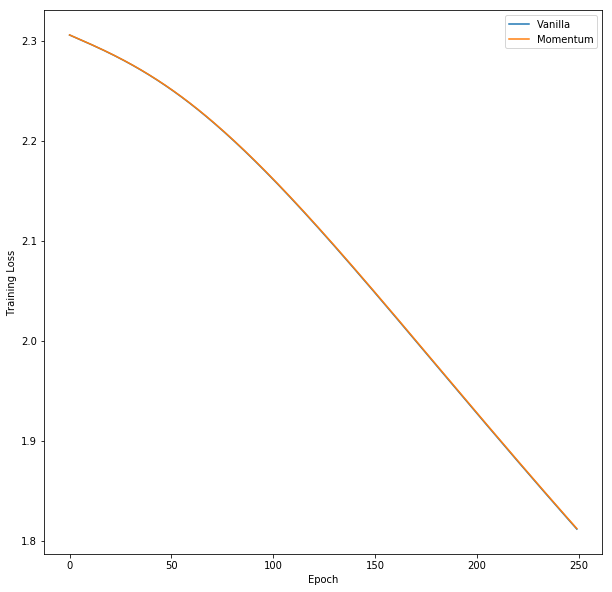

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [12]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""

beta = 0.9


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""
v_w1 = 0
v_w2 = 0
v_b1 = 0
v_b2 = 0


# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        v_w1 = (beta * v_w1) + ((1.0 - beta)*grad_W1*grad_W1)
        v_w2 = (beta * v_w2) + ((1.0 - beta)*grad_W2*grad_W2)
        v_b1 = (beta * v_b1) + ((1.0 - beta)*grad_b1*grad_b1)
        v_b2 = (beta * v_b2) + ((1.0 - beta)*grad_b2*grad_b2)

        



        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        W1 = W1 - ((eta * grad_W1) / np.sqrt(v_w1 + 0.000001))
        W2 = W2 - ((eta * grad_W2) / np.sqrt(v_w2 + 0.000001))
        b1 = b1 - ((eta * grad_b1) / np.sqrt(v_b1 + 0.000001))
        b2 = b2 - ((eta * grad_b2) / np.sqrt(v_b2 + 0.000001))
       

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.197029 Accuracy 0.495143
Epoch 10 Loss 1.422950 Accuracy 0.849714
Epoch 20 Loss 0.909293 Accuracy 0.885143
Epoch 30 Loss 0.612334 Accuracy 0.896857
Epoch 40 Loss 0.442915 Accuracy 0.904000
Epoch 50 Loss 0.341723 Accuracy 0.908286
Epoch 60 Loss 0.277145 Accuracy 0.910571
Epoch 70 Loss 0.232897 Accuracy 0.912857
Epoch 80 Loss 0.200813 Accuracy 0.914286
Epoch 90 Loss 0.176581 Accuracy 0.916000
Epoch 100 Loss 0.157738 Accuracy 0.917429
Epoch 110 Loss 0.142492 Accuracy 0.918000
Epoch 120 Loss 0.129902 Accuracy 0.918286
Epoch 130 Loss 0.119399 Accuracy 0.919714
Epoch 140 Loss 0.110408 Accuracy 0.920857
Epoch 150 Loss 0.102550 Accuracy 0.922000
Epoch 160 Loss 0.095659 Accuracy 0.921429
Epoch 170 Loss 0.089575 Accuracy 0.922857
Epoch 180 Loss 0.084135 Accuracy 0.923143
Epoch 190 Loss 0.079292 Accuracy 0.924000
Epoch 200 Loss 0.074911 Accuracy 0.924857
Epoch 210 Loss 0.070941 Accuracy 0.925714
Epoch 220 Loss 0.067376 Accuracy 0.925714
Epoch 230 Loss 0.064136 Accuracy 0.926000
Epo

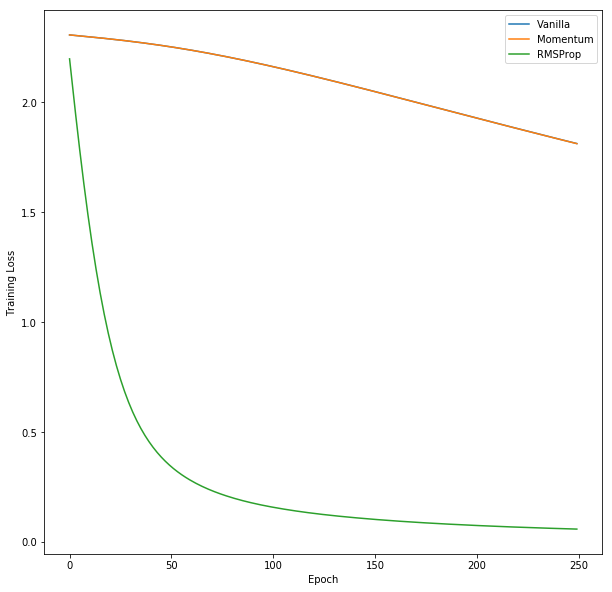

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [22]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

beta1 = 0.9
beta2 = 0.99
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""

m_w1 = 0
m_w2 = 0
m_b1 = 0
m_b2 = 0

v_w1 = 0
v_w2 = 0
v_b1 = 0
v_b2 = 0


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

"""
You probably need to initialize your variance and momentum here...
"""


# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        m_w1 = (beta1 * m_w1) + ((1 - beta1) * grad_W1)
        m_w2 = (beta1 * m_w2) + ((1 - beta1) * grad_W2)
        m_b1 = (beta1 * m_b1) + ((1 - beta1) * grad_b1)
        m_b2 = (beta1 * m_b2) + ((1 - beta1) * grad_b2)

        v_w1 = (beta2 * v_w1) + ((1 - beta2) * grad_W1 * grad_W1)
        v_w2 = (beta2 * v_w2) + ((1 - beta2) * grad_W2 * grad_W2)
        v_b1 = (beta2 * v_b1) + ((1 - beta2) * grad_b1 * grad_b1)
        v_b2 = (beta2 * v_b2) + ((1 - beta2) * grad_b2 * grad_b2)

        m_w1h = m_w1 / (1 - np.power(beta1, (i * num_batches) + (j + 1)))
        m_w2h = m_w2 / (1 - np.power(beta1, (i * num_batches) + (j + 1)))
        m_b1h = m_b1 / (1 - np.power(beta1, (i * num_batches) + (j + 1)))
        m_b2h = m_b2 / (1 - np.power(beta1, (i * num_batches) + (j + 1)))

        v_w1h = v_w1 / (1 - np.power(beta2, (i * num_batches) + (j + 1)))
        v_w2h = v_w2 / (1 - np.power(beta2, (i * num_batches) + (j + 1)))
        v_b1h = v_b1 / (1 - np.power(beta2, (i * num_batches) + (j + 1)))
        v_b2h = v_b2 / (1 - np.power(beta2, (i * num_batches) + (j + 1)))
        
        W1 = W1 - (eta * m_w1h / np.sqrt(v_w1h + 0.0000001))
        W2 = W2 - (eta * m_w2h / np.sqrt(v_w2h + 0.0000001))
        b1 = b1 - (eta * m_b1h / np.sqrt(v_b1h + 0.0000001))
        b2 = b2 - (eta * m_b2h / np.sqrt(v_b2h + 0.0000001))

    
        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.200508 Accuracy 0.478286
Epoch 10 Loss 1.407518 Accuracy 0.861714
Epoch 20 Loss 0.896129 Accuracy 0.891143
Epoch 30 Loss 0.598120 Accuracy 0.897714
Epoch 40 Loss 0.427592 Accuracy 0.905143
Epoch 50 Loss 0.326354 Accuracy 0.908000
Epoch 60 Loss 0.262002 Accuracy 0.912000
Epoch 70 Loss 0.218206 Accuracy 0.913429
Epoch 80 Loss 0.186520 Accuracy 0.914571
Epoch 90 Loss 0.162802 Accuracy 0.916571
Epoch 100 Loss 0.144388 Accuracy 0.918286
Epoch 110 Loss 0.129605 Accuracy 0.918000
Epoch 120 Loss 0.117384 Accuracy 0.918571
Epoch 130 Loss 0.107081 Accuracy 0.919429
Epoch 140 Loss 0.098145 Accuracy 0.920857
Epoch 150 Loss 0.090604 Accuracy 0.921143
Epoch 160 Loss 0.083929 Accuracy 0.922000
Epoch 170 Loss 0.077960 Accuracy 0.923429
Epoch 180 Loss 0.072762 Accuracy 0.923429
Epoch 190 Loss 0.068027 Accuracy 0.923429
Epoch 200 Loss 0.063819 Accuracy 0.924571
Epoch 210 Loss 0.060126 Accuracy 0.924857
Epoch 220 Loss 0.056687 Accuracy 0.924857
Epoch 230 Loss 0.053664 Accuracy 0.925143
Epo

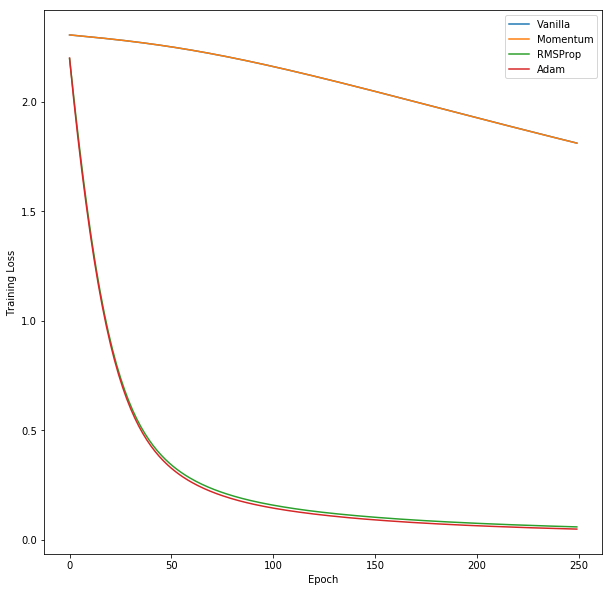

In [23]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()